# Compute lake area

### 0. Import libraries and load data

In [1]:
import os
import cv2
import sys
import copy
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from ipywidgets import interact, widgets
from scipy.ndimage import binary_dilation

plt.style.use('seaborn-v0_8')

FIRST_DATE = "1984-03"
LAST_DATE = "2012-05"
DILATION_SIZE = 3
SPATIAL_RESOLUTION = 30
MISSING_DATA_THRESHOLD = 0.5
DATA_PATH = "../data/processed/"
GROUND_TRUTH_PATH = "../data/ground_truth/"

%matplotlib inline

In [2]:
# load water index maps
water_index_map_names = [name for name in os.listdir(DATA_PATH) if ".tif" in name]
water_index_map_ =  rasterio.open(DATA_PATH + water_index_map_names[0])
water_index_maps = [rasterio.open(DATA_PATH + name).read(1) for name in water_index_map_names]


In [3]:
# load ground truth maps
ground_truth_map_names = [name for name in os.listdir(GROUND_TRUTH_PATH) if ".tif" in name]
ground_truth_map_ =  rasterio.open(GROUND_TRUTH_PATH + ground_truth_map_names[0])
ground_truth_maps = [rasterio.open(GROUND_TRUTH_PATH + name).read(1) for name in ground_truth_map_names]


### 1. Analyze the data

In [4]:
def analyze_tif_file(tif_file):
    # compute the distances covered by this map
    latitudinal_distance = tif_file.bounds.right - tif_file.bounds.left
    longitudinal_distance = tif_file.bounds.top - tif_file.bounds.bottom

    # create a list with descriptions of the data properties
    data_descriptions = [
        f"The data has {tif_file.count} band(s).",
        f"The shape of the raster data is {tif_file.height} rows x {tif_file.width} columns.",
        f"The coordinate reference system is {tif_file.crs}. The bounds are relative to the origin of this crs.",
        f"The bounds of the data are: {tif_file.bounds}.",
        f"The map covers a latitudinal distance of {latitudinal_distance} and a longitudinal distance of {longitudinal_distance}.",
    ]

    # concatenate in a string the described data properties and display them
    print("\n".join(data_descriptions))

In [5]:
analyze_tif_file(water_index_map_)

The data has 1 band(s).
The shape of the raster data is 848 rows x 442 columns.
The coordinate reference system is EPSG:32655. The bounds are relative to the origin of this crs.
The bounds of the data are: BoundingBox(left=714555.0, bottom=-3898785.0, right=727815.0, top=-3873345.0).
The map covers a latitudinal distance of 13260.0 and a longitudinal distance of 25440.0.


In [6]:
analyze_tif_file(ground_truth_map_)

The data has 1 band(s).
The shape of the raster data is 848 rows x 442 columns.
The coordinate reference system is EPSG:32655. The bounds are relative to the origin of this crs.
The bounds of the data are: BoundingBox(left=714555.0, bottom=-3898785.0, right=727815.0, top=-3873345.0).
The map covers a latitudinal distance of 13260.0 and a longitudinal distance of 25440.0.


In [7]:
def plot_map(water_index_map, ground_truth_map):
    fig, ax = plt.subplots(1, 3) 
    fig.set_size_inches(10, 5)

    # plot the histogram of pixel-level water index
    ax[0].hist(water_index_map.flatten(), bins=100)
    ax[0].set_xlabel("Water index value")
    ax[0].set_ylabel("Count")
    ax[0].set_title(f"Histogram of the pixel-level water index")

    # plot the water index map
    ax[1].imshow(water_index_map)
    ax[1].set_title("Water index map")
    ax[1].grid(False)

    # plot the ground truth map
    ax[2].imshow(ground_truth_map)
    ax[2].set_title("Ground truth map")
    ax[2].grid(False)

    plt.tight_layout()
    plt.show()

    # compute and display the minimum and maximum elevation values
    min_water_index = str(round(water_index_map.min(), 2))
    max_water_index = str(round(water_index_map.max(), 2))

    print(f"The minimum and maximum values of the water index are {min_water_index} and {max_water_index}.")

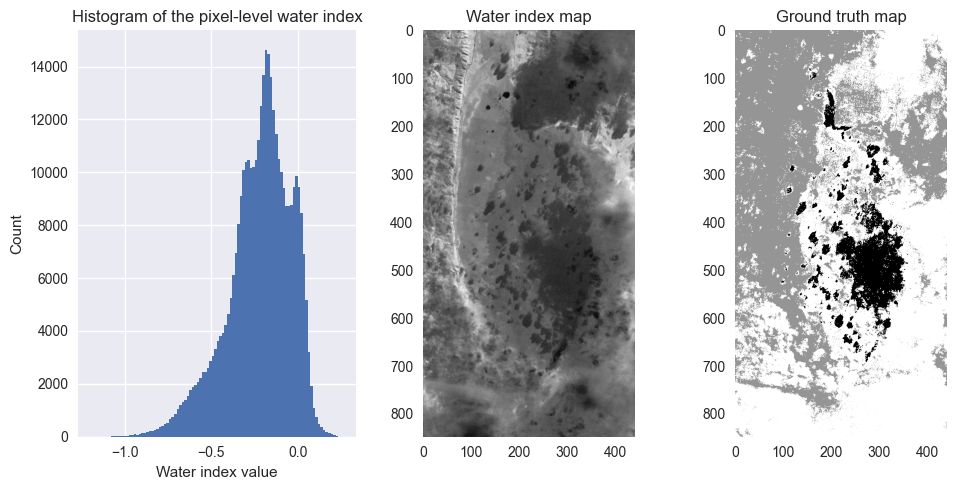

The minimum and maximum values of the water index are -1.2 and 0.26.


In [8]:
# extract the band from the water index
water_index_map = water_index_map_.read(1)

# extract the band from the ground truth
ground_truth_map = ground_truth_map_.read(1)

plot_map(water_index_map, ground_truth_map)

### 2. Detect the lake

In [38]:
"""
create a dictionary for water index and one for ground truth pairs where the year-month is the index
now there can be multiple images per month and we randomly picked one per month
attention - if there are two images with the same year and month, they are concatenated into a numpy array
"""
water_index_months = [
    file_name[-14:-4]
    for file_name in water_index_map_names
]
water_index_dataset = {
    k: v
    for k, v in sorted(
        dict(zip(water_index_months, water_index_maps)).items(), key=lambda x: x[0]
    )
}

ground_truth_months = [
    file_name[-14:-4]
    for file_name in ground_truth_map_names
]
ground_truth_dataset = {
    k: v
    for k, v in sorted(
        dict(zip(ground_truth_months, ground_truth_maps)).items(), key=lambda x: x[0]
    )
}

# throw an error these dictionaries don't have the same keys
assert water_index_dataset.keys() == ground_truth_dataset.keys()


In [39]:
def get_min_max_values(water_index_dataset):
    # get the global min and max values of the water index across the dataset
    min_value = sys.maxsize
    max_value = -sys.maxsize

    for water_index in water_index_dataset.values():
        min_value = min(min_value, water_index.flatten().min())
        max_value = max(max_value, water_index.flatten().max())

    return min_value, max_value

In [61]:
def preprocess_ground_truth(ground_truth):
    ground_truth_copy = copy.deepcopy(ground_truth) 
    # replace no data 0 with 1 for not water
    ground_truth_copy[ground_truth_copy == 0] = 1
    # replace water detection 2 with 0 for water
    ground_truth_copy[ground_truth_copy == 2] = 0
    # represent water with 1 and no water with 0
    ground_truth_copy = 1 - ground_truth_copy

    return ground_truth_copy

In [41]:
min_value, max_value = get_min_max_values(water_index_dataset)
# define the space for thresholds
thresholds = np.linspace(min_value, max_value, 10)
f1_scores = []

for threshold in tqdm(thresholds):
    # initialize values
    f1 = 0
    number_of_images = 0
    number_of_noisy_images = 0

    for index, date in enumerate(water_index_dataset.keys()):
        water_detection = water_index_dataset[date] > threshold
        ground_truth = ground_truth_dataset[date]

        # consider the ground truth only if it has less than 50% missing data
        if sum(ground_truth.flatten() == 0) / len(ground_truth.flatten()) <= MISSING_DATA_THRESHOLD:
            number_of_images += 1
            preprocessed_ground_truth = preprocess_ground_truth(ground_truth)
            f1 += f1_score(preprocessed_ground_truth.flatten(), water_detection.flatten(), average='weighted')
        else:
            number_of_noisy_images += 1

    f1_scores.append(f1 / number_of_images)

print(f"The number of ground truth images with more than {MISSING_DATA_THRESHOLD * 10}% missing data is {number_of_noisy_images}")

100%|██████████| 10/10 [03:17<00:00, 19.71s/it]

The number of ground truth images with more than 5.0% missing data is 26


In [58]:
threshold_f1 = pd.DataFrame({"threshold": thresholds, "f1_score": f1_scores}).sort_values("f1_score", ascending=False)
threshold_f1

,threshold,f1_score
3,-0.055642,0.913097
6,2.460376,0.728157
7,3.299049,0.727973
5,1.621704,0.727838
9,4.976395,0.727586
8,4.137722,0.727586
4,0.783031,0.726836
2,-0.894315,0.103503
1,-1.732988,0.097132
0,-2.571661,0.097107


### 3. Analyze the lake evolution

In [59]:
best_detections = []
best_threshold = threshold_f1["threshold"].iloc[0]

for index, date in enumerate(water_index_dataset.keys()):
    best_detections.append(water_index_dataset[date] > best_threshold)

In [62]:
def display_image(index):

    try: 
        if dilated_detections is not None:
            fig, ax = plt.subplots(1, 5)
            fig.set_size_inches(24, 6)
    except NameError:
        fig, ax = plt.subplots(1, 3)
        fig.set_size_inches(14, 6)

    date = list(water_index_dataset.keys())[index]

    ax[0].imshow(water_index_dataset[date])
    ax[0].set_title("Water index")
    ax[0].axis("off")

    ax[1].imshow(ground_truth_dataset[date])
    ax[1].set_title("Ground truth")
    ax[1].axis("off")

    ax[2].imshow(best_detections[index])
    ax[2].set_title("Detection")
    ax[2].axis("off")

    try:
        if dilated_detections is not None:
            ax[3].imshow(dilated_detections[index])
            ax[3].set_title("Dilated detection")
            ax[3].axis("off")

            ax[4].imshow(isolated_detections[index])
            ax[4].set_title("Isolated detection")
            ax[4].axis("off")
    except NameError:
        pass

    fig.suptitle(f"Year-month: {date}")

    plt.show()
    plt.close()

interact(display_image, index=widgets.IntSlider(min=0, max=len(water_index_dataset) - 1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=186), Output()), _dom_classes=('widget-inter…

<function __main__.display_image(index)>

### 4. Compute the area evolution

In [45]:
def estimate_area_by_month(best_detections, ground_truth_months):
    # create a data frame that stores the lake area in square kilometers for every month with observations
    areas = []

    # pixel area in square kilometers
    pixel_area = SPATIAL_RESOLUTION ** 2 / (1000 ** 2)

    for detection in best_detections:
        areas.append(detection.sum() * pixel_area)

    known_area_by_month = pd.DataFrame({"date": ground_truth_months, "area": areas})

    # create a data frame that contains the months with missing observations
    missing_dates = []

    for year in range(int(FIRST_DATE[:4]), int(LAST_DATE[:4]) + 1):
        for month in range(1, 13):
            date = f"{year}-{str(month).zfill(2)}"

            if (FIRST_DATE <= date <= LAST_DATE) and date not in ground_truth_months:
                missing_dates.append(date)

    missing_area_by_month = pd.DataFrame({"date": missing_dates, "area": [np.nan] * len(missing_dates)})

    # store in one data frame the lake area estimation for each month
    area_by_month = pd.concat([known_area_by_month, missing_area_by_month]).sort_values("date")
    
    return area_by_month

In [46]:
def plot_lake_area_by_month(best_detections, ground_truth_months):
    # get estimated lake area by month
    area_by_month = estimate_area_by_month(best_detections, ground_truth_months)

    # display lake area evolution
    fig = px.line(
        area_by_month[~area_by_month["area"].isna()],
        x="date",
        y="area",
        markers=True,
        labels={"area": "area in square kilometers"},
        title="Observations of area evolution",
    )
    fig.show()


In [51]:
plot_lake_area_by_month(best_detections, ground_truth_dataset.keys())

### 5. Isolate area of interest

In [52]:
def get_largest_lake_mask(best_detections):
    # find the mask of the lake when it has the largest area
    largest_area_overall = -sys.maxsize
    largest_area_mask_overall = None
    dilated_detections = []

    # iterate over each observation of the lake
    for i in range(len(best_detections)):
        largest_area = -sys.maxsize
        largest_area_mask = None

        # dilate the image and store it
        diltated_img = binary_dilation(best_detections[i], structure=np.ones((DILATION_SIZE, DILATION_SIZE), np.bool_))
        diltated_img_cast = diltated_img.astype(np.uint8) * 255
        dilated_detections.append(diltated_img)

        # get the connected components
        ret, labels = cv2.connectedComponents(diltated_img_cast)

        # find the biggest connected component from the current observation
        for label in range(1, ret):
            mask = np.zeros(labels.shape, dtype=np.uint8)
            mask[labels == label] = 1
            mask_area = mask.sum()

            if mask_area > largest_area:
                largest_area = mask_area
                largest_area_mask = mask

        # if the lake has an area larger than the previous largest area, update the mask
        if largest_area > largest_area_overall:
            largest_area_overall = largest_area
            largest_area_mask_overall = largest_area_mask

    return largest_area_mask_overall, largest_area_overall, dilated_detections        


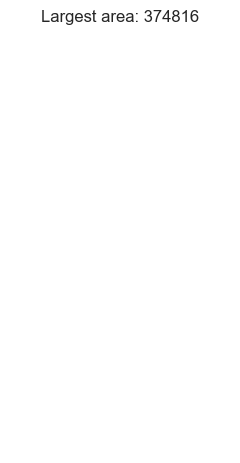

In [53]:
largest_area_mask_overall, largest_area_overall, dilated_detections = get_largest_lake_mask(best_detections)

# display the mask of the lake when it has the largest area
plt.imshow(largest_area_mask_overall)
plt.title(f"Largest area: {largest_area_overall}")
plt.axis("off")

plt.show()

In [23]:
def remove_adjacent_water_bodies(best_detections, largest_area_mask_overall):
    # remove all water detections that do not intersect with the largest found mask
    isolated_detections = []

    # iterate over each observation
    for i in range(len(best_detections)):
        # prepare the data
        detection = best_detections[i]
        detection_cast = detection.astype(np.uint8) * 255

        # get the connected components
        ret, labels = cv2.connectedComponents(detection_cast)

        # initiate the mask
        mask = np.array(labels, dtype=np.uint32)

        # remove all connected components that do not intersect with the largest found mask
        for label in range(1, ret):
            if (((mask == label).astype(np.uint8) + largest_area_mask_overall) == 2).sum() > 0:
                mask[labels == label] = ret
            else:
                mask[labels == label] = 0

        # store these isolated detections into an array
        mask = (mask / ret).astype(np.uint8)
        isolated_detections.append(mask)

    return isolated_detections

In [54]:
isolated_detections = remove_adjacent_water_bodies(best_detections, largest_area_mask_overall)
interact(display_image, index=widgets.IntSlider(min=0, max=len(water_index_dataset) - 1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=186), Output()), _dom_classes=('widget-inter…

<function __main__.display_image(index)>

In [56]:
plot_lake_area_by_month(isolated_detections, ground_truth_dataset.keys())

In [26]:
# TODO: compare the predicted area with the ground truth